In [3]:
%reload_ext autoreload
%autoreload 2

import warnings
import shutil
import numpy as np
import pandas as pd
import flexiznam as flz
from functools import partial
from znamutils import slurm_it
from cottage_analysis.io_module.harp import load_harpmessage
from cottage_analysis.io_module import onix as onix_io
from cottage_analysis.preprocessing import onix as onix_prepro
from cottage_analysis.preprocessing import find_frames, synchronisation
from cottage_analysis.imaging.common.find_frames import find_imaging_frames
from cottage_analysis.imaging.common import imaging_loggers_formatting as format_loggers
import matplotlib.pyplot as plt

In [24]:
project='hey2_3d-vision_foodres_20220101'
session_name='PZAH8.2h_S20230302'
flexilims_session = flz.get_flexilims_session(project)
conflicts = "skip"
recording_type = "two_photon"
protocol_base = "SpheresPermTubeReward"

exp_session = flz.get_entity(
    datatype="session", name=session_name, flexilims_session=flexilims_session
)
    
recordings = flz.get_entities(
    datatype="recording",
    origin_id=exp_session["id"],
    query_key="recording_type",
    query_value=recording_type,
    flexilims_session=flexilims_session,
)
recordings = recordings[recordings.name.str.contains(protocol_base)]

for i, recording_name in enumerate([recordings.name.iloc[0]]):
    recording = flz.get_entity(
        datatype="recording",
        name=recording_name,
        flexilims_session=flexilims_session,
    )
            
    # Find paths
    if type(recording) == str:
        recording = flz.get_entity(
            datatype="recording", name=recording, flexilims_session=flexilims_session
        )
        if recording is None:
            raise ValueError(f"Recording {recording} does not exist.")
    # Load files
    monitor_frames_ds = flz.Dataset.from_origin(
        origin_id=recording["id"],
        dataset_type="monitor_frames",
        flexilims_session=flexilims_session,
        conflicts=conflicts,
    )

    harp_messages, harp_ds = synchronisation.load_harpmessage(
        recording=recording, flexilims_session=flexilims_session, conflicts="skip"
    )
    monitor_frames_ds.path = monitor_frames_ds.path.parent / f"monitor_frames_df.pickle"


Loading existing harp_npz file...


In [25]:
suite2p_ds = flz.get_datasets(
    flexilims_session=flexilims_session,
    origin_name=recording.name,
    dataset_type="suite2p_traces",
    filter_datasets={"anatomical_only":3},
    allow_multiple=False,
    return_dataseries=False,
)
if "nframes" in suite2p_ds.extra_attributes:
    volume_number = float(suite2p_ds.extra_attributes["nframes"])
else:
    volume_number = float(
        np.load(suite2p_ds.path_full / "plane0" / "dff_ast.npy").shape[1]
    )
nplanes = float(suite2p_ds.extra_attributes["nplanes"])
fs = float(suite2p_ds.extra_attributes["fs"])
harp_npz_path = flz.get_datasets(
    flexilims_session=flexilims_session,
    origin_name=recording.name,
    dataset_type="harp_npz",
    allow_multiple=False,
    return_dataseries=False,
).path_full
# frame period calculated based of the frame rate in ops.npy
# subtracting 1 ms to account for the duration of the triggers
imaging_df = find_imaging_frames(
    harp_message=format_loggers.format_img_frame_logger(
        harpmessage_file=harp_npz_path, register_address=32
    ),
    frame_number=int(volume_number * nplanes),
    frame_period=(1 / fs) / nplanes,
    register_address=32,
    frame_period_tolerance=0.001,
)

2 frames are not 0.0658 s
ImagingFrames in video: 132353
ImagingFrame triggers: 132354


In [26]:
harp_npz_path = flz.get_datasets(
    flexilims_session=flexilims_session,
    origin_name=recording.name,
    dataset_type="harp_npz",
    allow_multiple=False,
    return_dataseries=False,
).path_full

harp_df=format_loggers.format_img_frame_logger(
    harpmessage_file=harp_npz_path, register_address=32
)

In [27]:
vs_df = synchronisation.generate_vs_df(
    recording,
    photodiode_protocol=5,
    flexilims_session=flexilims_session,
    project=None,
    harp_recording=None,
    onix_recording=None,
    conflicts="skip",
)

Loading existing monitor frames...
Removing frames in wrong order of frame indices.
Removed 1667 frames including:
0 negative diffs.
1667 duplicates.
Removed 0 frames including:
0 negative diffs.
0 duplicates.


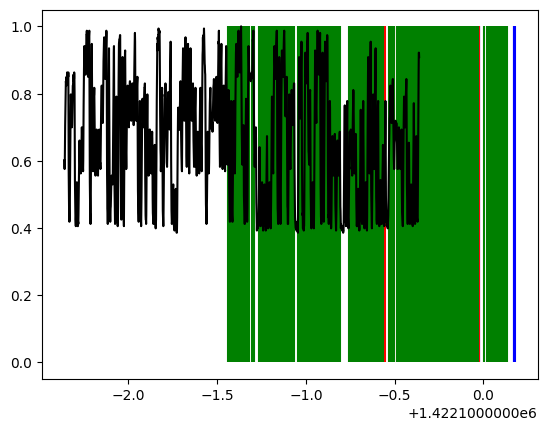

In [28]:
plt.vlines(x=harp_df[harp_df.RegisterAddress==32].HarpTime.values[-20:], ymin=0, ymax=1, color='b')
plt.vlines(x=imaging_df.HarpTime.values[-20:], ymin=0, ymax=1, color='r')
plt.plot(harp_messages["analog_time"][-8000:-6000], harp_messages["photodiode"][-8000:-6000]/np.nanmax(harp_messages["photodiode"][-8000:-6000]), color='k')
plt.vlines(x=vs_df["monitor_harptime"].values[-200:], ymin=0, ymax=1, color='g')


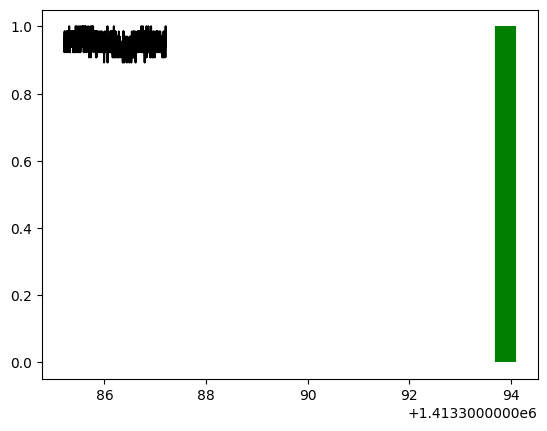

In [30]:
# plt.vlines(x=harp_df[harp_df.RegisterAddress==32].HarpTime.values[:20], ymin=0, ymax=1, color='b')
# plt.vlines(x=imaging_df.HarpTime.values[:20], ymin=0, ymax=1, color='r')
plt.plot(harp_messages["analog_time"][:2000], harp_messages["photodiode"][:2000]/np.nanmax(harp_messages["photodiode"][:2000]), color='k')
plt.vlines(x=vs_df["monitor_harptime"].values[:50], ymin=0, ymax=1, color='g')

In [23]:
harp_message = harp_df
register_address = 32
frame_period_tolerance = 0.001
frame_period = (1 / fs) / nplanes


frame_triggers = harp_message[harp_message.RegisterAddress == register_address]
frame_triggers = frame_triggers[frame_triggers.FrameTriggers == 1] # only keep frame onset
frame_triggers = frame_triggers.rename(
    columns={"Timestamp": "HarpTime"}, inplace=False
)

# shift diff by -1 to get the start of the frame
frame_triggers["HarpTime_diff"] = frame_triggers.HarpTime.diff().shift(-1)

frame_triggers["FramePeriod"] = np.nan
frame_triggers.loc[
    np.abs(frame_triggers["HarpTime_diff"] - frame_period)
    <= frame_period_tolerance,
    "FramePeriod",
] = 1
print(f"{np.sum(frame_triggers.FramePeriod!=1)} frames are not {frame_period:.4f} s")

2 frames are not 0.0658 s


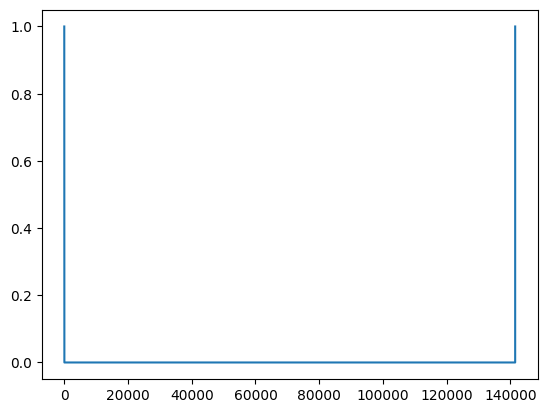

In [27]:
plt.plot(frame_triggers.FramePeriod!=1)